In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

In [3]:
df=pd.read_csv('Hotel Reservations.csv')

In [4]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [5]:
temp=df[df['arrival_date']==29]
temp=temp[temp['arrival_month']==2]
temp.shape

(37, 19)

In [6]:
list_to_drop= temp.index.tolist()

In [7]:
df.drop(list_to_drop,inplace=True)

In [8]:
df['date'] = pd.to_datetime(df['arrival_year'].astype(str) + '-' + df['arrival_month'].astype(str) + '-' + df['arrival_date'].astype(str))
df['quarter']=df['date'].dt.to_period('Q')
df_new=df[['quarter','room_type_reserved','avg_price_per_room','booking_status']]

In [9]:
room_type_cancellations=df_new.groupby(['room_type_reserved','booking_status']).agg(
    avg_booking_value=('avg_price_per_room', 'mean'),number_of_canc=('booking_status', 'count')).reset_index()

room_type_cancellations['total loss-profit']=room_type_cancellations['avg_booking_value']*\
room_type_cancellations['number_of_canc']

room_type_cancellations['total loss-profit'][::2]=room_type_cancellations['total loss-profit'][::2]*(-1)

/var/folders/r9/s7zsd2g16z1gx1whz5r99cpr0000gn/T/ipykernel_21765/3855903077.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  room_type_cancellations['total loss-profit'][::2]=room_type_cancellations['total loss-profit'][::2]*(-1)


In [10]:
a=room_type_cancellations[room_type_cancellations['booking_status']=='Canceled']
a[['room_type_reserved','avg_booking_value','number_of_canc','total loss-profit']]

,room_type_reserved,avg_booking_value,number_of_canc,total loss-profit
0,Room_Type 1,101.720218,9066,-922195.50
2,Room_Type 2,98.261228,228,-22403.56
4,Room_Type 3,105.375000,2,-210.75
6,Room_Type 4,132.545759,2068,-274104.63
8,Room_Type 5,138.279306,72,-9956.11
10,Room_Type 6,188.984557,406,-76727.73
12,Room_Type 7,227.854167,36,-8202.75


In [11]:
rooms_to_keep = ['Room_Type 1', 'Room_Type 4']
data_plot = room_type_cancellations[room_type_cancellations['room_type_reserved'].isin(rooms_to_keep)]

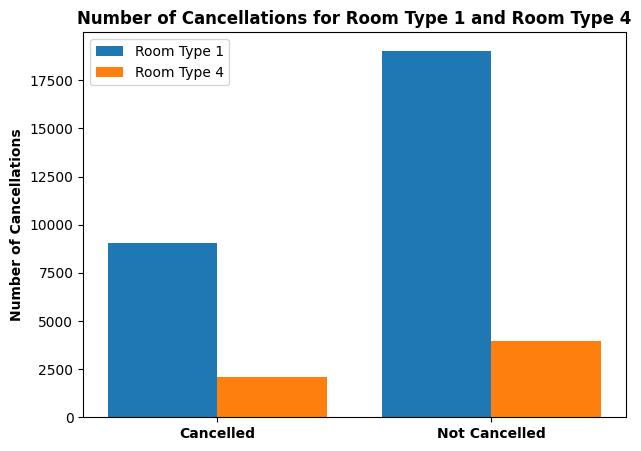

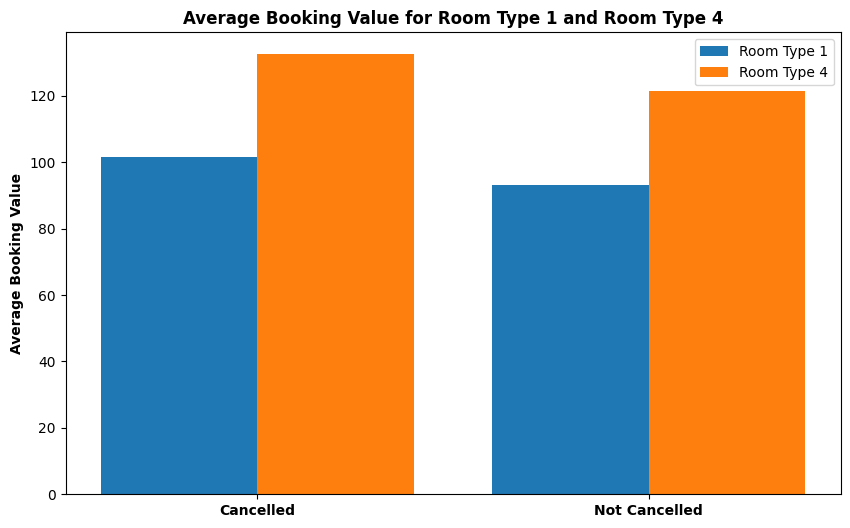

In [12]:
room_type_1_data = data_plot[data_plot['room_type_reserved'] == 'Room_Type 1']
room_type_4_data = data_plot[data_plot['room_type_reserved'] == 'Room_Type 4']
# Plot cancellations using a bar plot
plt.figure(figsize = (7, 5))
plt.bar([0, 1], room_type_1_data['number_of_canc'], width=0.4, label='Room Type 1')
plt.bar([0.4, 1.4], room_type_4_data['number_of_canc'], width=0.4, label='Room Type 4')
plt.xticks([0.2, 1.2], ['Cancelled', 'Not Cancelled'], fontweight='bold')
plt.ylabel('Number of Cancellations', fontweight='bold')
plt.title('Number of Cancellations for Room Type 1 and Room Type 4', fontweight='bold')
plt.legend()
plt.savefig('Number of cancellations.png',format='png')

plt.figure(figsize=(10, 6))
plt.bar([0, 1], room_type_1_data['avg_booking_value'], width=0.4, label='Room Type 1')
plt.bar([0.4, 1.4], room_type_4_data['avg_booking_value'], width=0.4, label='Room Type 4')
plt.xticks([0.2, 1.2], ['Cancelled', 'Not Cancelled'], fontweight='bold')
plt.ylabel('Average Booking Value',fontweight='bold')
plt.title('Average Booking Value for Room Type 1 and Room Type 4',fontweight='bold')
plt.legend()
plt.savefig('Number of cancellations_price.png')


In [13]:
room_type_profit_loss=room_type_cancellations.groupby('room_type_reserved')['total loss-profit'].rolling(window=2).\
sum().reset_index().dropna().drop('level_1',axis=1)

room_type_profit_loss['expected_revenue']=room_type_cancellations['total loss-profit'].iloc[1::2].values\
- room_type_cancellations['total loss-profit'].iloc[::2].values

room_type_profit_loss['loss_accrued']=room_type_cancellations['total loss-profit'][::2].values

room_type_profit_loss['%loss']=round((-1)*room_type_profit_loss['loss_accrued']*100/\
                                     room_type_profit_loss['expected_revenue'])

room_type_profit_loss['earned_revenue']=room_type_cancellations['total loss-profit'][1::2].values

room_type_profit_loss['%revenue']=round(room_type_profit_loss['total loss-profit']*100/\
                                        room_type_profit_loss['expected_revenue'])


room_type_profit_loss = room_type_profit_loss[['room_type_reserved' , 'earned_revenue' , 'loss_accrued', \
                                               'total loss-profit', 'expected_revenue', '%revenue' , '%loss']]


In [14]:
room_type_profit_loss

,room_type_reserved,earned_revenue,loss_accrued,total loss-profit,expected_revenue,%revenue,%loss
1,Room_Type 1,1774170.86,-922195.50,851975.36,2696366.36,32.0,34.0
3,Room_Type 2,38387.64,-22403.56,15984.08,60791.20,26.0,37.0
5,Room_Type 3,305.00,-210.75,94.25,515.75,18.0,41.0
7,Room_Type 4,483874.87,-274104.63,209770.24,757979.50,28.0,36.0
9,Room_Type 5,22584.30,-9956.11,12628.19,32540.41,39.0,31.0
11,Room_Type 6,98917.12,-76727.73,22189.39,175644.85,13.0,44.0
13,Room_Type 7,16318.58,-8202.75,8115.83,24521.33,33.0,33.0


In [15]:
room_type_profit_loss['expected_revenue%']=room_type_profit_loss['expected_revenue']*100/sum(room_type_profit_loss['expected_revenue'])

In [16]:
date_cancellations= df_new.groupby(['quarter','booking_status']).agg(
    avg_booking_value=('avg_price_per_room', 'mean'),number_of_canc=('booking_status', 'count')).reset_index()

date_cancellations['total loss-profit']=date_cancellations['avg_booking_value']*date_cancellations['number_of_canc']
date_cancellations['total loss-profit'][::2]=date_cancellations['total loss-profit'][::2]*(-1)

/var/folders/r9/s7zsd2g16z1gx1whz5r99cpr0000gn/T/ipykernel_21765/1282149124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_cancellations['total loss-profit'][::2]=date_cancellations['total loss-profit'][::2]*(-1)


In [17]:
quarter_profit_loss=date_cancellations.groupby('quarter')['total loss-profit'].rolling(window=2).\
sum().reset_index().dropna().drop('level_1',axis=1)

quarter_profit_loss['expected_revenue']=date_cancellations['total loss-profit'].iloc[1::2].values\
- date_cancellations['total loss-profit'].iloc[::2].values

quarter_profit_loss['loss_accrued']=date_cancellations['total loss-profit'][::2].values

quarter_profit_loss['%loss']=round((-1)*quarter_profit_loss['loss_accrued']*100/\
                                     quarter_profit_loss['expected_revenue'])

quarter_profit_loss['earned_revenue']=date_cancellations['total loss-profit'][1::2].values

quarter_profit_loss['%revenue']=round(quarter_profit_loss['total loss-profit']*100/\
                                        quarter_profit_loss['expected_revenue'])


quarter_profit_loss = quarter_profit_loss[['quarter' , 'earned_revenue' , 'loss_accrued', \
                                               'total loss-profit', 'expected_revenue', '%revenue' , '%loss']]


In [18]:
quarter_profit_loss
a=date_cancellations[date_cancellations['booking_status']=='Canceled']
a[['quarter','avg_booking_value','number_of_canc','total loss-profit']]

,quarter,avg_booking_value,number_of_canc,total loss-profit
0,2017Q3,98.280000,610,-59950.80
2,2017Q4,85.492365,351,-30007.82
4,2018Q1,93.688527,1147,-107460.74
6,2018Q2,112.941317,3234,-365252.22
8,2018Q3,121.351448,3730,-452640.90
10,2018Q4,106.375107,2806,-298488.55


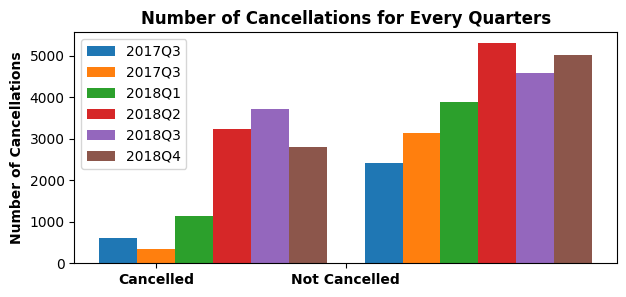

In [20]:
quarter_1 = date_cancellations[date_cancellations['quarter'] == '2017Q3']
quarter_2 = date_cancellations[date_cancellations['quarter'] == '2017Q4']
quarter_3 = date_cancellations[date_cancellations['quarter'] == '2018Q1']
quarter_4 = date_cancellations[date_cancellations['quarter'] == '2018Q2']
quarter_5 = date_cancellations[date_cancellations['quarter'] == '2018Q3']
quarter_6 = date_cancellations[date_cancellations['quarter'] == '2018Q4']


# Plot cancellations using a bar plot
plt.figure(figsize=(7, 3))
plt.bar([0, 1.4], quarter_1['number_of_canc'], width=0.2, label='2017Q3')
plt.bar([0.2, 1.6], quarter_2['number_of_canc'], width=0.2, label='2017Q3')
plt.bar([0.4, 1.8], quarter_3['number_of_canc'], width=0.2, label='2018Q1')
plt.bar([0.6, 2], quarter_4['number_of_canc'], width=0.2, label='2018Q2')
plt.bar([0.8, 2.2], quarter_5['number_of_canc'], width=0.2, label='2018Q3')
plt.bar([1, 2.4], quarter_6['number_of_canc'], width=0.2, label='2018Q4')

plt.xticks([0.2, 1.2], ['Cancelled', 'Not Cancelled'],fontweight='bold')
plt.ylabel('Number of Cancellations',fontweight='bold')
plt.title('Number of Cancellations for Every Quarters',fontweight='bold')
plt.legend()
plt.savefig('Number of Quarterly_price.png',format='png')
plt.show()

In [228]:
df_thresh=df[['quarter','room_type_reserved','lead_time','avg_price_per_room','booking_status']]

In [229]:
lead_time_df=df_thresh.groupby(['room_type_reserved','booking_status']).agg(avg_room_price=('avg_price_per_room','mean'),
    maxi=('lead_time', 'max'),mini=('lead_time', 'min'), avg=('lead_time', 'mean'), count=('lead_time', 'count'),
    lq=('lead_time', lambda x: np.percentile(x, q=25)),uq=('lead_time', lambda x: np.percentile(x, q=75)),).reset_index()

In [230]:
lead_time_df=lead_time_df[lead_time_df['booking_status']=='Canceled']

In [231]:
lead_time_df

,room_type_reserved,booking_status,avg_room_price,maxi,mini,avg,count,lq,uq
0,Room_Type 1,Canceled,101.720218,443,0,151.450695,9066,64.0,229.0
2,Room_Type 2,Canceled,98.261228,381,2,155.697368,228,73.0,217.0
4,Room_Type 3,Canceled,105.375000,180,116,148.000000,2,132.0,164.0
6,Room_Type 4,Canceled,132.545759,355,0,95.234526,2068,39.0,144.0
8,Room_Type 5,Canceled,138.279306,276,2,123.902778,72,51.5,181.0
10,Room_Type 6,Canceled,188.984557,346,0,91.100985,406,30.0,144.0
12,Room_Type 7,Canceled,227.854167,213,0,69.555556,36,24.0,114.0


In [232]:
df_thresh=df[['quarter','room_type_reserved','lead_time','avg_price_per_room','booking_status']]

In [233]:
lead_time_df=df_thresh.groupby(['quarter','booking_status']).agg(avg_room_price=('avg_price_per_room','mean'),
    maxi=('lead_time', 'max'),mini=('lead_time', 'min'), avg=('lead_time', 'mean'), count=('lead_time', 'count'),
    lq=('lead_time', lambda x: np.percentile(x, q=25)),uq=('lead_time', lambda x: np.percentile(x, q=75)),).reset_index()

In [234]:
lead_time_df

,quarter,booking_status,avg_room_price,maxi,mini,avg,count,lq,uq
0,2017Q3,Canceled,98.280000,273,0,113.172131,610,34.0,162.0
1,2017Q3,Not_Canceled,96.701507,327,0,49.936258,2416,4.0,74.0
2,2017Q4,Canceled,85.492365,296,1,116.495726,351,99.0,174.0
3,2017Q4,Not_Canceled,83.790969,289,0,48.778451,3137,10.0,66.0
4,2018Q1,Canceled,93.688527,182,0,47.505667,1147,16.0,68.5
5,2018Q1,Not_Canceled,82.024134,199,0,36.947071,3892,5.0,54.0
6,2018Q2,Canceled,112.941317,443,0,123.745207,3234,53.0,188.0
7,2018Q2,Not_Canceled,107.132819,323,0,64.960777,5303,13.0,100.0
8,2018Q3,Canceled,121.351448,433,0,163.093029,3730,88.0,220.0
9,2018Q3,Not_Canceled,118.981484,346,0,77.397123,4588,17.0,125.0
